In [2]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel

In [3]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)

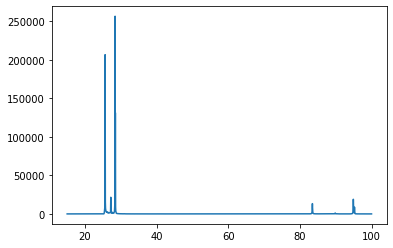

In [4]:
path =  'Data/si111_30_20_ohne.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])
plt.plot(data[0],data[1])

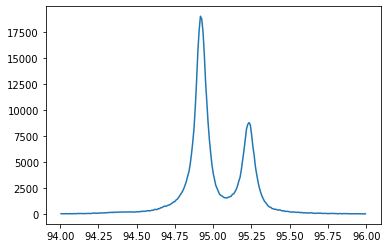

In [5]:
x=[[],[]]
for i in range(len(data[1])):
    if 94<data[0,i]<96:
        x[0].append(data[0,i])
        x[1].append(data[1,i])
plt.plot(x[0],x[1])

In [6]:
for i in range(len(data[0])):
    if data[0,i]>=62:
        print(i)
        break

5624


b1 = [25,26.2]->[1196,1339]  
a1 = [28,29]->[1555,1675]  
b2 = [52.55,52.8]->[4493,4523]  
a2 = [58.5,59.4]->[5205,5313]  
b3 = [82.5,84.5]->[8077,8317]  
a3 = [94,96]->[9454,9693]  

In [7]:
#modell erstellen b1 = [25,26.2]->[1196,1339]  
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=25.5,min=25,max=26.2)
pars_voigt["scale1"].set(100)

#Fitten
out_voigt = model_voigt.fit(data[1,1196:1339],x=data[0,1196:1339],params=pars_voigt,weights=1/data[2,1196:1339],nan_policy='propagate')
b1f=out_voigt.fit_report()
b1p=np.array([np.arange(25,26.2,0.001),out_voigt.eval(x=np.arange(25,26.2,0.001))])

In [8]:
#modell erstellen a1 = [28,29]->[1555,1675]    
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=28.4,min=28,max=29)
pars_voigt["o2"].set(value=28.5,min=28,max=29)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,1555:1675],x=data[0,1555:1675],params=pars_voigt,weights=1/data[2,1555:1675],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(28,29,0.001),out_voigt.eval(x=np.arange(28,29,0.001))])

In [9]:
#modell erstellen    b2 = [52.55,52.8]->[4493,4497]4493:4497
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0084,min=0,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=52.677,min=52.6,max=52.8)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,4493:4523],x=data[0,4493:4523],weights=1/data[2,4493:4523],params=pars_voigt,nan_policy='propagate')
b2f=out_voigt.fit_report()
b2p=np.array([np.arange(52.55,52.8,0.001),out_voigt.eval(x=np.arange(52.55,52.8,0.001))])

In [10]:
#modell erstellen a2 = [58.5,59.4]->[5205,5313]     
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=58.8,min=58.6,max=58.9)
pars_voigt["o2"].set(value=59,min=58.9,max=59.4)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,5205:5313],x=data[0,5205:5313],params=pars_voigt,weights=1/data[2,5205:5313],nan_policy='propagate')
a2f=out_voigt.fit_report()
a2p=np.array([np.arange(58.5,59.4,0.001),out_voigt.eval(x=np.arange(58.5,59.4,0.001))])

In [11]:
#modell erstellen    b3 = [82.5,84.5]->[8077,8317]
model_voigt = lmfit.model.Model(voigt1)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0084,min=0,max=1)
pars_voigt["g1"].set(value=0.041,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=83.5,min=82.5,max=84.5)
pars_voigt["scale1"].set(20)

#Fitten
out_voigt = model_voigt.fit(data[1,8077:8317],x=data[0,8077:8317],weights=1/data[2,8077:8317],params=pars_voigt,nan_policy='propagate')
b3f=out_voigt.fit_report()
b3p=np.array([np.arange(82.5,84.5,0.001),out_voigt.eval(x=np.arange(82.5,84.5,0.001))])

In [12]:
#modell erstellen a3 = [94,96]->[9454,9693]       
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
#pars_voigt["a"].set(0.1)
#pars_voigt["b"].set(20)
pars_voigt["o1"].set(value=94.8,min=94,max=96)
pars_voigt["o2"].set(value=95.25,min=94,max=96)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,9454:9693],x=data[0,9454:9693],params=pars_voigt,weights=1/data[2,9454:9693],nan_policy='propagate')
a3f=out_voigt.fit_report()
a3p=np.array([np.arange(94,96,0.001),out_voigt.eval(x=np.arange(94,96,0.001))])

(52.0, 60.0)

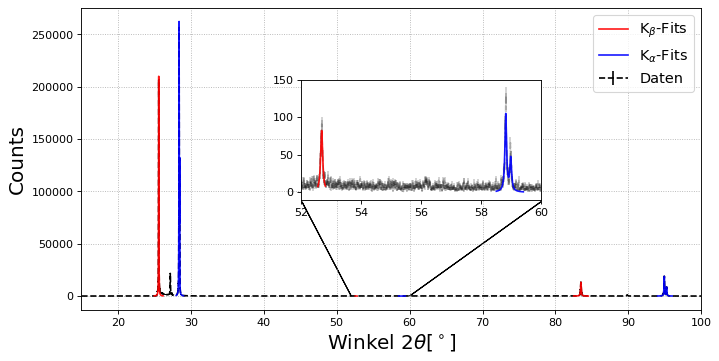

In [17]:
fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',label='Daten')
plt.plot(b1p[0],b1p[1],zorder=10,label='K'r'$_\beta$''-Fits',color='r',alpha=0.9)
plt.plot(a1p[0],a1p[1],zorder=10,label='K'r'$_\alpha$''-Fits',color='b',alpha=0.9)
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.plot(b3p[0],b3p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a3p[0],a3p[1],zorder=10,color='b',alpha=0.9)

plt.legend(fontsize=13)
plt.grid(axis='both',linestyle=':')
plt.xlim(15,100)
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
#plt.axvline(52,-.002,.08,color='k')
#plt.axvline(60,-.002,.08,color='k')
plt.arrow(45.25,90000,6.75,-90000)
plt.arrow(78,90000,-18,-90000)

# this is an inset axes over the main axes
a = plt.axes([.4, .4, .3, .3])
plt.plot(b2p[0],b2p[1],zorder=10,color='r',alpha=0.9)
plt.plot(a2p[0],a2p[1],zorder=10,color='b',alpha=0.9)
plt.errorbar(data[0],data[1],yerr=data[2],zorder=5,mfc='black',color='k',linestyle='--',alpha=0.2)
plt.ylim(-10,150)
plt.xlim(52,60)

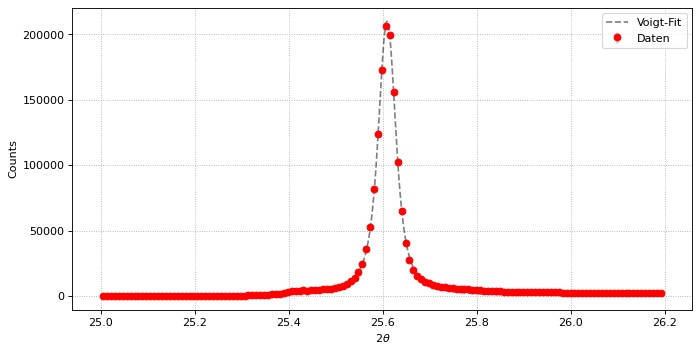

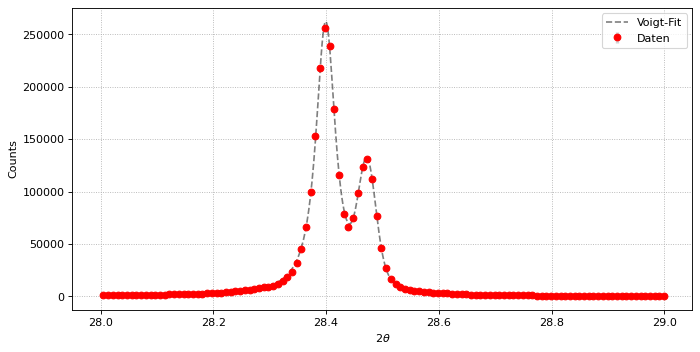

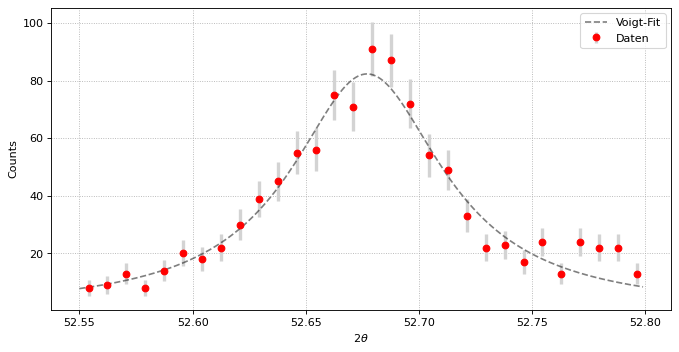

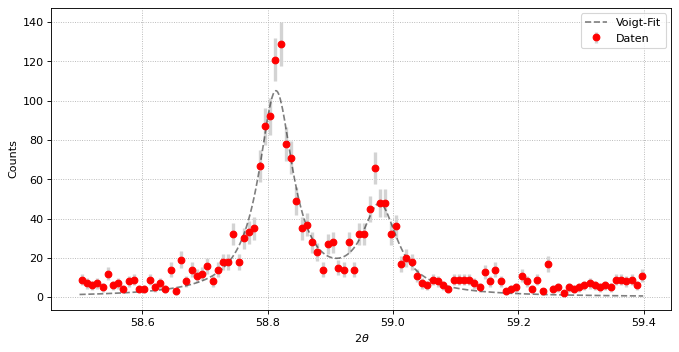

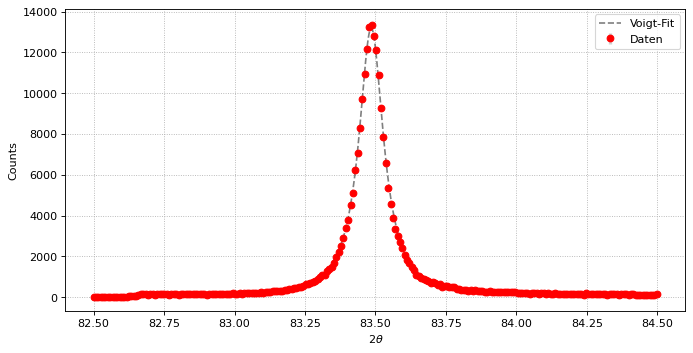

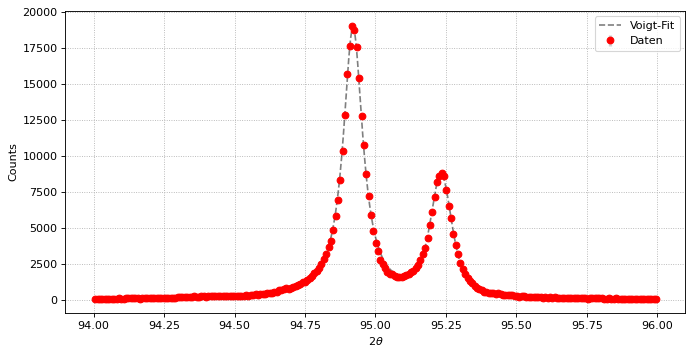

In [14]:
#plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,1196:1339],data[1,1196:1339],yerr=data[2,1196:1339],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b1p[0],b1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,1555:1675],data[1,1555:1675],yerr=data[2,1555:1675],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,4493:4523],data[1,4493:4523],yerr=data[2,4493:4523],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b2p[0],b2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,5205:5313],data[1,5205:5313],yerr=data[2,5205:5313],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a2p[0],a2p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,8077:8317],data[1,8077:8317],yerr=data[2,8077:8317],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(b3p[0],b3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()


fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,9454:9693],data[1,9454:9693],yerr=data[2,9454:9693],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a3p[0],a3p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts")
plt.xlabel("2"r"$\theta$")
plt.legend()